<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/5-ImageClass/CNN_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datayı Githubdan hızlıca Colabe çek

Bu dataset kaggledan alınmış FER 2013 challenge datasıdır.  

https://www.kaggle.com/datasets/msambare/fer2013?resource=download

In [23]:
!wget https://github.com/onuralpArsln/MlAiTutorialProjects/raw/main/5-ImageClass/Fer2013Kaggle.zip -q -O data.zip

Dosyayı zipten çıkart

In [24]:
!unzip -q data.zip

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Burada, os modülünü ve TensorFlow'un image araçlarını kullanarak klasörleri tarayıp görüntüleri okuyoruz ve yeniden boyutlandırıyoruz. İşlem sırasında etiketler de belirleniyor.

In [32]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np


# 📂 Dataset ana klasörleri
test_dir = 'test'   # test/angry, test/disgust, test/fear ...
train_dir = 'train' # train/angry, train/disgust, train/fear ...

# 📌 Görselleri yükleyen fonksiyon (48x48 dataset için)
def load_images_from_directory(base_dir, label, img_size=(48, 48), limit=1000):
    images = []
    labels = []
    count = 0
    for file_name in os.listdir(base_dir):
        if count >= limit:  # 300'den sonra dur
            break
        if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            file_path = os.path.join(base_dir, file_name)
            # grayscale yaptık çünkü kaynak grayscale
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size, color_mode="grayscale")
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # normalize
            images.append(img_array)
            labels.append(label)
            count += 1
    return images, labels

# Duygu klasörleri ve etiketleri
emotion_dirs = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "surprise": 5,
    "sad": 6
}

# --- Train verisi ---
train_images, train_labels = [], []
for emotion, label in emotion_dirs.items():
    img_dir = os.path.join(train_dir, emotion)
    images, labels = load_images_from_directory(img_dir, label=label)
    train_images.extend(images)
    train_labels.extend(labels)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# --- Test verisi ---
test_images, test_labels = [], []
for emotion, label in emotion_dirs.items():
    img_dir = os.path.join(test_dir, emotion)
    images, labels = load_images_from_directory(img_dir, label=label)
    test_images.extend(images)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


Data Preprocessing - Resizing and Splitting
Bu aşamada, görüntüleri normalleştirdiğimizden emin olduk ve eğitim/test verilerini doğru şekilde böldük. Şimdi doğrulama verilerini eğitim verisinden ayırabiliriz:

In [33]:
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels


In [34]:
print("Elindeki veri miktarı ve test train dağlımı")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Elindeki veri miktarı ve test train dağlımı
X_train shape: (6436, 48, 48, 1)
X_test shape: (5900, 48, 48, 1)
y_train shape: (6436,)
y_test shape: (5900,)
Train samples: 6436
Test samples: 5900


Model Building

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  # 7 sınıf
])

# 🔧 Derleme
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # integer label için
              metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Gelişmiş model yapısı

BatchNormalization → daha hızlı ve stabil öğrenme

Dropout → overfitting önleme

Dense(256) → daha güçlü temsil

Adam(learning_rate=0.0005) → öğrenme hızını kontrol etme

EarlyStopping + ModelCheckpoint → gereksiz uzun eğitimden kurtarır ve en iyi modeli kaydeder


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# 🔧 Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),   # normalize feature maps
    MaxPooling2D(2, 2),
    Dropout(0.25),          # overfitting'i azaltmak için

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),  # daha büyük dense katmanı
    Dropout(0.5),                   # son katmanda daha güçlü regularization
    Dense(7, activation='softmax')  # 7 sınıf
])

# 🔧 Öğrenme oranı ile oynayabilirsin
optimizer = Adam(learning_rate=0.0005)  # default=0.001, düşürmek daha stabil öğrenme sağlar

# 🔧 Derleme
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 🔧 Eğitim için callback ekle (early stopping + en iyi modeli kaydet)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)



In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,911 (2.36 MB)

 Trainable params: 619,463 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
!pip install graphviz pydot

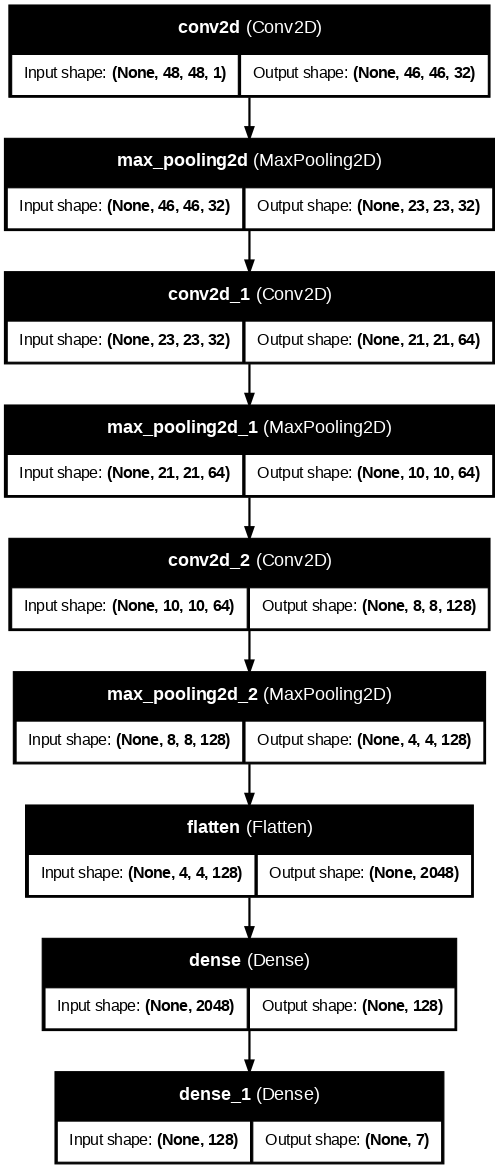

In [8]:
# Visualize model architecture None implies flexible batch si
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)

Train

In [35]:
# 🚀 Eğitme
history = model.fit(
    X_train, y_train,
    epochs=50,                        # daha uzun eğitim şansı ver
    batch_size=128,                    # batch boyutunu ayarlayabilirsin
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 932ms/step - accuracy: 0.2100 - loss: 1.9279 - val_accuracy: 0.0188 - val_loss: 4.8056
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 964ms/step - accuracy: 0.2521 - loss: 1.8646 - val_accuracy: 0.0188 - val_loss: 5.1336
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 954ms/step - accuracy: 0.2531 - loss: 1.8403 - val_accuracy: 0.1585 - val_loss: 4.6991
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 924ms/step - accuracy: 0.2829 - loss: 1.7879 - val_accuracy: 0.0988 - val_loss: 4.1044
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 850ms/step - accuracy: 0.2944 - loss: 1.7676 - val_accuracy: 0.1442 - val_loss: 4.0215
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 903ms/step - accuracy: 0.3378 - loss: 1.7017 - val_accuracy: 0.1944 - val_loss: 3.4011
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 918ms/step - accuracy: 0.3537 - loss: 1.6626 - val_accuracy: 0.2271 - val_loss: 2.7191
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 931ms/step - accuracy: 0.3669 - loss: 1.6389 - val_accu

Evaluation and Predictions

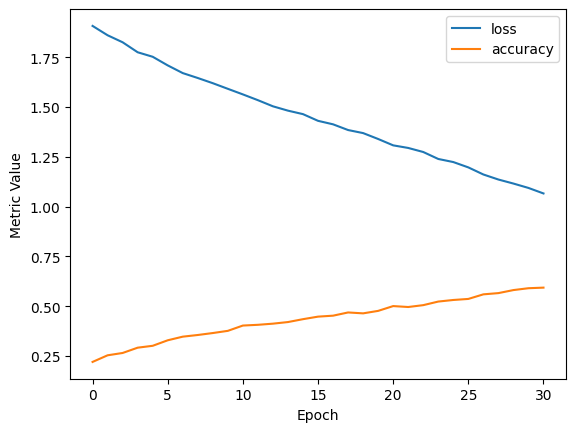

In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


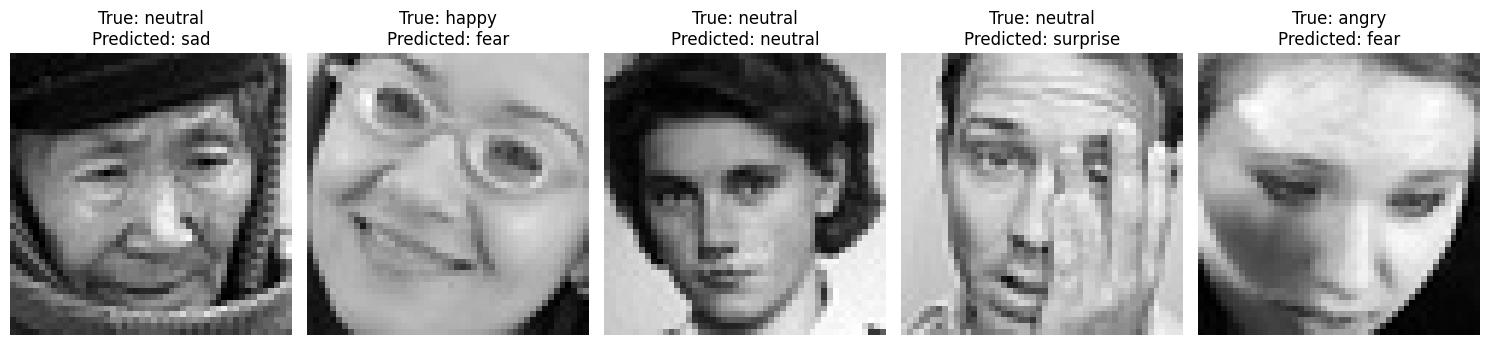

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 7 duygulu sınıf isimleri
class_names = ["angry", "disgust", "fear", "happy", "neutral", "surprise", "sad"]

# Test setinden 5 rastgele örnek seç
random_indices = np.random.choice(len(X_test), 5, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    sample_image = X_test[idx]
    # Model tahmini (48x48 grayscale)
    prediction = model.predict(sample_image.reshape(1, 48, 48, 1))
    predicted_label_idx = np.argmax(prediction)
    predicted_label = class_names[predicted_label_idx]

    true_label = class_names[y_test[idx]]

    # Görüntüyü göster
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_image.squeeze(), cmap="gray")  # tek kanallı için squeeze ve gray
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()



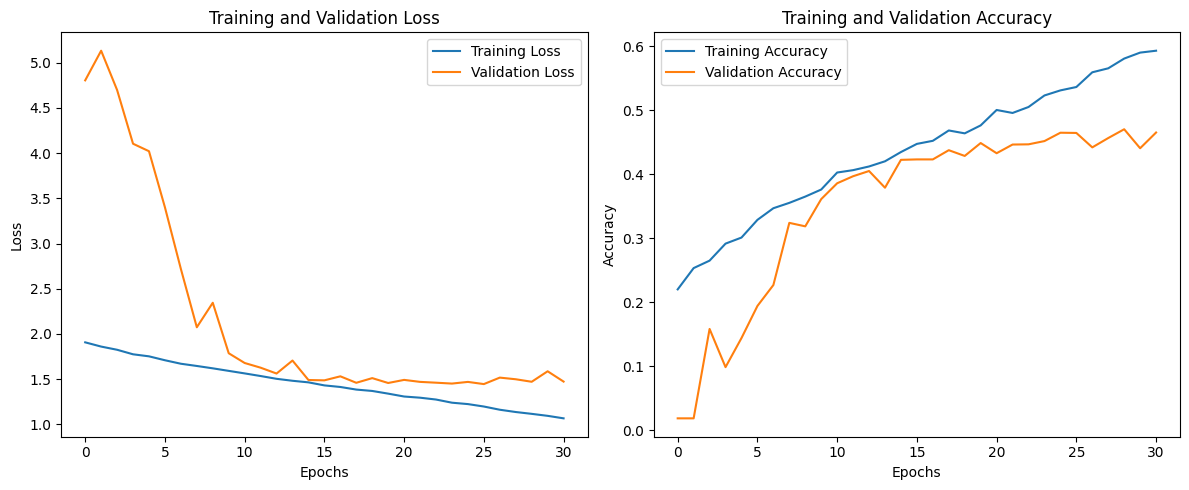

In [38]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


kaydetme

In [ ]:
# Modeli kaydet
model.save('/content/cbs_classifier.keras')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8743  100  8743    0     0  57804      0 --:--:-- --:--:-- --:--:-- 57900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


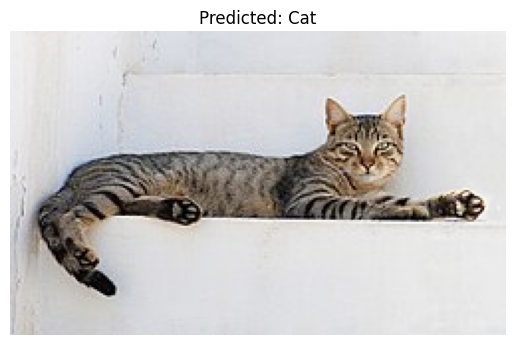

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1️⃣ Modeli yükle (.keras veya .h5)
model = tf.keras.models.load_model('/content/cbs_classifier.keras')

# 2️⃣ İnternetten resmi indir ve test.png olarak kaydet
!curl -L "https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/250px-Cat_August_2010-4.jpg" -o test.png

# 3️⃣ Resmi aç, boyutlandır ve normalize et
image = Image.open("test.png").convert("RGB")
image_resized = image.resize((128, 128))
image_array = np.array(image_resized) / 255.0
image_array = np.expand_dims(image_array, axis=0)  # (1, 128, 128, 3)

# 4️⃣ Tahmin yap
prediction = model.predict(image_array)

# 3 sınıf için argmax kullan
class_names = ["Cat", "Rabbit", "Squirrel"]
predicted_label_idx = np.argmax(prediction[0])
predicted_label = class_names[predicted_label_idx]

# 5️⃣ Sonucu göster
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()


Eğitilmiş modeli alıp fine tune etmek yani eğitimine devam etmek1

In [ ]:
# Modeli tekrar yükle
model = tf.keras.models.load_model("/content/cbs_classifier.keras")

# Yeni veri ile eğitimi devam ettir
history = model.fit(
    X_train_new, y_train_new,  # yeni eklenmiş + eski data olabilir
    epochs=20,
    validation_data=(X_test_new, y_test_new),
    batch_size=32
)

# Güncellenmiş modeli kaydet
model.save("cbs_classifier_finetuned.keras")
